## Import essential packages

We'll now import the packages required to execute the project properly.
These are Python packages/modules that are often used for different purposes in deep learning, data manipulation, visualization, and evaluation.

In [24]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from google.colab import drive
import os
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Import the dataset and resize the images

In the beginning, we have two possibilities for retrieving the dataset: upload it from our local files and give the right path, or use Kaggle to retrieve it. Once the dataset is accessible, we begin image preprocessing. 
We start by defining transformations for preprocessing the images. These steps involve scaling each image to a standard size of 180 × 180 pixels and applying normalization. Normalization sets the pixel values to have a mean of 0.5 and a standard deviation of 0.5 in each color channel, guaranteeing similar data qualities.

In [25]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Define the path to your dataset root directory
root_dataset = '/content/drive/MyDrive/archive/Data'

# Load the dataset using ImageFolder
satellite_dataset = datasets.ImageFolder(root=root_dataset)

# Print class names (genres) and corresponding labels
print("Class names and labels:")
print(satellite_dataset.classes)

# Print the number of images in each class
print("\nNumber of images in each class :")
for class_name, class_count in satellite_dataset.class_to_idx.items():
    print(f"{class_name}: {len(os.listdir(os.path.join(root_dataset, class_name)))} images")

Class names and labels:
['cloudy', 'desert', 'green_area', 'water']

Number of images in each class :
cloudy: 1500 images
desert: 1131 images
green_area: 1500 images
water: 1500 images


In [27]:
#Resize the images to 180x180
transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the dataset
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/archive/Data', transform=transform)

### Split the dataset

Divide a dataset into 3 independent sets: training, validation, and testing. The total number of samples for each subset is determined by specified proportions—70% for training, 20% for validation, and the remainder for testing. 
Using PyTorch's random_split() method, the dataset is divided at random into the required percentages. 

In [28]:
# Define the sizes of each split
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset randomly
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
print("# training samples={}, validation samples={}, test samples={}".format(len(train_data), len(val_data), len(test_data)))

# training samples=3941, validation samples=1126, test samples=564


### Data Visualization

Now we generate a grid of subplots, each with an image representing a class. It creates a figure and then gathers picture indices for each class until the target count is reached. After that, it iterates over each class, obtains the photos, organizes them as subplots, assigns the subplot title to the class name, hides axes, and displays the images. The result is a grid with sample photos from various classes.

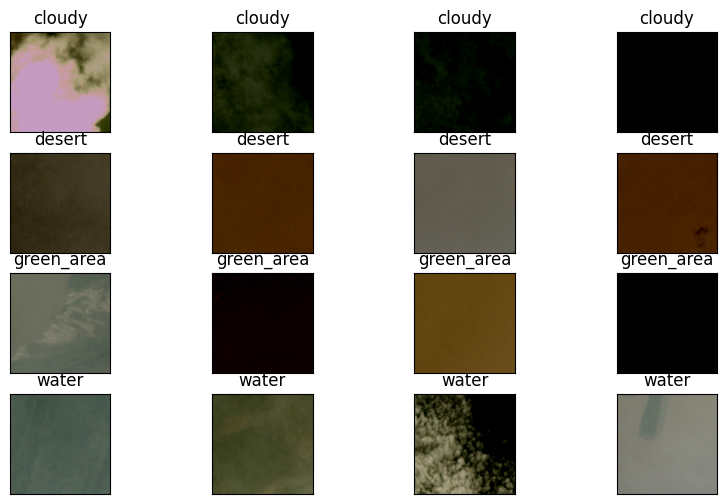

In [29]:
# Assuming train_data is your DataLoader object
fig = plt.figure(figsize=(10, 6))  # Adjust the size of the figure as needed
fig.tight_layout()

class_names = ['cloudy', 'desert', 'green_area', 'water']

num_images_per_genre = 4 # Display 2 images for each satellite images type

class_indices = {class_name: [] for class_name in class_names}

# Collect indices of images for each classes
for i, (_, label) in enumerate(train_data):
    class_name = class_names[label]
    if len(class_indices[class_name]) < num_images_per_genre:
        class_indices[class_name].append(i)
    if all(len(indices) == num_images_per_genre for indices in class_indices.values()):
        break

# Display images
for i, class_name in enumerate(class_names):
    for j, index in enumerate(class_indices[class_name]):
        img, _ = train_data.dataset[index]
        img = img.permute(1, 2, 0)  # Rearrange dimensions from (3, 180, 180) to (180, 180, 3)

        t = fig.add_subplot(len(class_names), num_images_per_genre, i*num_images_per_genre + j + 1)
        t.set_title(class_name)  # Set title as genre name
        t.axes.get_xaxis().set_visible(False)
        t.axes.get_yaxis().set_visible(False)
        plt.imshow(img)

plt.show()

#### class CustomDataLoader:
This class is a customized version of a DataLoader, a type of Python tool used to handle datasets and batch process data for neural network training. The CustomDataLoader object is initialized with a variety of arguments to set its behavior using the `__init__} function. It derives from PyTorch's DataLoader class and, if needed, expands on its features.

In [30]:
class CustomDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0, collate_fn=None,
                 pin_memory=False, drop_last=False, timeout=0,
                 worker_init_fn=None):
        # Call the constructor of the parent class DataLoader
        super(CustomDataLoader, self).__init__(
            dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler,
            batch_sampler=batch_sampler, num_workers=num_workers,
            collate_fn=collate_fn, pin_memory=pin_memory, drop_last=drop_last,
            timeout=timeout, worker_init_fn=worker_init_fn
        )

### Define data loaders

We set up the data loaders.  
Every loader is designed to function with a certain subset of the dataset, whether for testing, validation, or training. 
While the 'val_loader' and 'test_loader' use the same batch size, they do not shuffle their datasets, which is a usual practice for validation and test data to maintain consistency throughout assessment. The 'train_loader' is set to a batch size of 32 and supports data shuffling to introduce unpredictability during training epochs. 
No additional processes are created for the purpose of loading data, as evidenced by the option 'num_workers' being set to 0 across all loaders. 
Configuring these loaders improves efficiency and makes it easier to train and evaluate models on various subsets.

In [31]:
# setting up data loaders for training, validation, and testing datasets
batch_size=32
train_loader=CustomDataLoader(train_data,batch_size=batch_size,num_workers=2, shuffle=True)
val_loader=CustomDataLoader(val_data,batch_size=batch_size,num_workers=2,shuffle=False)
test_loader=CustomDataLoader(test_data,batch_size=batch_size,num_workers=2,shuffle=False)

## 3. LSTM

For sequence prediction tasks, this code defines an LSTM (Long Short-Term Memory) model in PyTorch. Below is a summary of the functions of each part:

Class Definition: In PyTorch, the basic class for all neural network modules is nn.Module, of which LSTMModel is a subclas
s.
Builder (__init__):
Sets the LSTMModel's initial parameters:
input_size: The input features' dimensionality.
hidden_size: The quantity of features in the LSTM's hidden state.
hidden_size2: The quantity of features in the fully connected (FC) network's second hidden layer.
num_layers: The LSTM layer count.
num_classes: The total count of output
 Alasses.
assembles the model's layers:
self.lstm: LSTM layer with batch_first=True, num_layers, input size input_size, and hidden size h
self.fc1: First fully connected (linear) layer; hidden_size for input and hidden_size2 for output.
self.fc2: Input size hidden_size2 and output size num_classes for the second fully connected layer.
specifies a layer that will drop out with a probability of 0.
5.
Forward Pass (forward
): This method reshapes the input tensor x to meet the LSTM's predicted input shape (batch_size, 1, input_size).
sets the initial cell and hidden states, h0 and c0, to zeros.
obtains the output by passing the input through the LSTM layer.
In order to avoid overfitting, dropout is applied on the final output sequence element, which is the result of the final time step.
ReLU activation is performed after the output has passed through the first fully connected layer (selfReturns output.
.
In general, this model learns to predict the output (out) from the input sequence given sequential input data (x). For applications involving classification or regression, it employs fully connected layers and an LSTM layer to capture sequential dependencies..fc1).
idden_size.


In [32]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        # Initialize the model parameters
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.num_layers = num_layers
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        # Define the first fully connected layer
        self.fc1 = nn.Linear(hidden_size, hidden_size2)
        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_size2, num_classes)
        # Define the dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Reshape input tensor to be 3-dimensional (batch_size, seq_length, input_size)
        x = x.view(x.size(0), 1, -1)
        batch_size = x.size(0)
        # Initialize the initial hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        # Forward pass through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Apply dropout to the last output sequence element
        out = self.dropout(out[:, -1, :])
        # Apply ReLU activation to the output of the first fully connected layer
        out = F.relu(self.fc1(out))
        # Pass the output through the second fully connected layer to get the final output
        out = self.fc2(out)
        return out

#### Training the model: 

Train the model for '50 epochs' separately. 

In [33]:
#  Define hyperparameters
input_size = 180*180*3
hidden_size1 = 256
hidden_size2 = 128
num_layers = 2
num_classes = len(train_data.dataset.classes)
learning_rate = 0.0001
num_epochs = 50

# This line of code determines whether to use a CPU or a GPU for PyTorch operations based on CUDA availability. 
# It configures the device to 'cuda' for CUDA-enabled GPUs; otherwise, it defaults to 'cpu' for CPU-based processing.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size1, hidden_size2, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training the model
train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses
best_val_accuracy = 0.0  # Variable to track the best validation accuracy

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    train_loss = 0.0  # Initialize training loss for the epoch
    # Iterate over the training dataset
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item() * images.size(0)  # Accumulate training loss

    train_loss /= len(train_loader.dataset)  # Average training loss for the epoch
    train_losses.append(train_loss)  # Store the training loss

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize validation loss
    correct = 0  # Initialize number of correct predictions
    total = 0  # Initialize total number of predictions

    with torch.no_grad():
        # Iterate over the validation dataset
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item() * images.size(0)  # Accumulate validation loss

            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)  # Increment total count
            correct += (predicted == labels).sum().item()  # Count correct predictions

    val_loss /= len(val_loader.dataset)  # Average validation loss
    val_losses.append(val_loss)  # Store validation loss

    val_accuracy = correct / total  # Calculate validation accuracy
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0  # Initialize number of correct predictions on test set
test_total = 0  # Initialize total number of predictions on test set

with torch.no_grad():
    # Iterate over the test dataset
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        test_total += labels.size(0)  # Increment total count
        test_correct += (predicted == labels).sum().item()  # Count correct predictions

test_accuracy = test_correct / test_total  # Calculate test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch [1/50], Train Loss: 1.0803, Val Loss: 0.7196, Val Accuracy: 0.6377
Epoch [2/50], Train Loss: 0.6391, Val Loss: 0.5399, Val Accuracy: 0.6989
Epoch [3/50], Train Loss: 0.5684, Val Loss: 0.4989, Val Accuracy: 0.6998
Epoch [4/50], Train Loss: 0.5456, Val Loss: 0.4719, Val Accuracy: 0.7771
Epoch [5/50], Train Loss: 0.5271, Val Loss: 0.4508, Val Accuracy: 0.7798
Epoch [6/50], Train Loss: 0.5223, Val Loss: 0.4439, Val Accuracy: 0.7824
Epoch [7/50], Train Loss: 0.5253, Val Loss: 0.4378, Val Accuracy: 0.8055
Epoch [8/50], Train Loss: 0.5136, Val Loss: 0.4519, Val Accuracy: 0.7851
Epoch [9/50], Train Loss: 0.5179, Val Loss: 0.4314, Val Accuracy: 0.8446
Epoch [10/50], Train Loss: 0.5114, Val Loss: 0.4098, Val Accuracy: 0.8499
Epoch [11/50], Train Loss: 0.4825, Val Loss: 0.4211, Val Accuracy: 0.8455
Epoch [12/50], Train Loss: 0.5005, Val Loss: 0.3988, Val Accuracy: 0.8677
Epoch [13/50], Train Loss: 0.4919, Val Loss: 0.4282, Val Accuracy: 0.8366
Epoch [14/50], Train Loss: 0.5070, Val Loss: 0.

In [34]:
#creating the Confusion Matrix
try:
   from torchmetrics import ConfusionMatrix
except:
    !pip install torchmetrics
    from torchmetrics import ConfusionMatrix

# Create an instance of ConfusionMatrix
conmat = ConfusionMatrix(num_classes=4)  # Assuming you have 4 classes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [35]:
def evaluate(loader, model):
    total = 0.
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)  # Move input tensor to the same device as the model
            labels = labels.to(device)  # Move labels to the same device as the model
            outputs = model(images)
            _, pred = torch.max(outputs, dim=1)
            total += (pred == labels).sum().item()
            # Assuming `conmat` is defined somewhere else
            conmat.update(pred.cpu(), labels.cpu())  # Move predictions and labels back to CPU for confusion matrix
    return total, (total / len(loader.dataset))

#### Validation and Testing

Validate LSTM Model by calculating the accuracy of the model on the validation set and test set for 50 epochs.

In [36]:
#Evaluate the validation data for accuracy for 50 epochs
nitems,accuracy=evaluate(val_loader,model)
print("val_accuracy={:.4f}".format(accuracy))

val_accuracy=0.8801


In [37]:
#Evaluate the test data for accuracy for 50 epochs
nitems,accuracy=evaluate(test_loader,model)
print("test_accuracy={:.4f}".format(accuracy))

test_accuracy=0.8688


In [38]:
# After confusion matrix with predictions and targets is updated
print(conmat.compute().cpu().numpy())

[[433  15   9   1]
 [  9 345   0   0]
 [  0   0 379  63]
 [  1   0 111 324]]


#### Evaluation of all the results of LSTM

##### 1. Create Confusion Matrix

Plot a Confusion matrix for 50 epochs.

<Axes: >

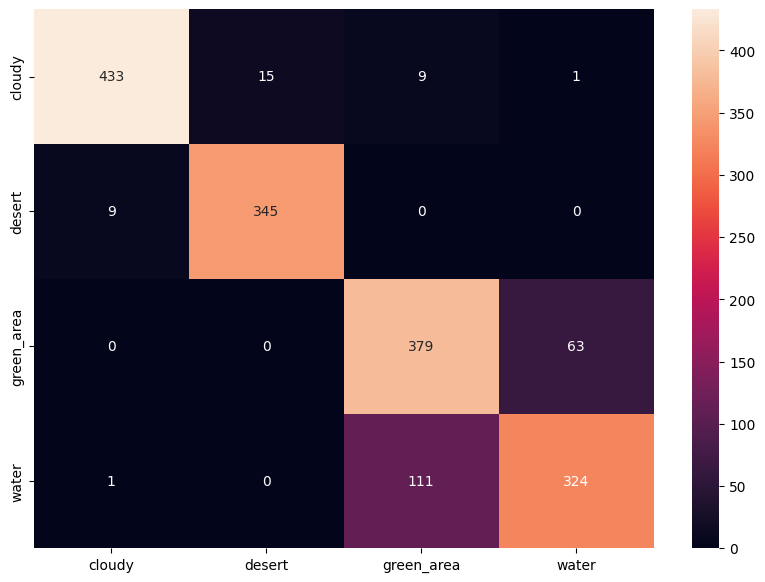

In [39]:
try:
    import seaborn as sb  # Try importing seaborn
except:
    %pip install seaborn  # If seaborn is not installed, install it
    import seaborn as sb  # Then import seaborn

# Assuming 'class_names' is a list of class names in the same order as your confusion matrix
class_names = ['cloudy', 'desert', 'green_area', 'water']

# Assuming 'conmat' is a confusion matrix object
x = conmat.compute().cpu().numpy()

# Plotting the heatmap
plt.figure(figsize=(10, 7))
sb.heatmap(x, annot=True, fmt=".0f", xticklabels=class_names, yticklabels=class_names)

##### 2. Create the classification report

It computes precise evaluation metrics for each class in a multi-class classification task for 50 epochs.

In [40]:
# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0  # Initialize the number of correct predictions on the test set
test_total = 0  # Initialize the total number of examples in the test set
predictions = []  # List to store predicted labels
true_labels = []  # List to store true labels

# Iterate over the test data loader
with torch.no_grad():  # Disable gradient computation during inference
    for images, labels in test_loader:
        images = images.to(device)  # Move images to the device (GPU if available)
        labels = labels.to(device)  # Move labels to the device

        outputs = model(images)  # Forward pass through the model
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        predictions.extend(predicted.cpu().numpy())  # Append predicted labels to the list
        true_labels.extend(labels.cpu().numpy())  # Append true labels to the list

        test_total += labels.size(0)  # Increment total number of examples
        test_correct += (predicted == labels).sum().item()  # Increment correct predictions

# Calculate test accuracy
test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')  # Print test accuracy

# Generate classification report
print(classification_report(true_labels, predictions, target_names=test_data.dataset.classes))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy: 0.8688
              precision    recall  f1-score   support

      cloudy       0.97      0.96      0.96       147
      desert       0.97      0.97      0.97       120
  green_area       0.75      0.85      0.80       150
       water       0.82      0.72      0.77       147

    accuracy                           0.87       564
   macro avg       0.88      0.87      0.87       564
weighted avg       0.87      0.87      0.87       564



##### 3. Determine the precision, recall, and F1 score

For each class, compute the precision, recall, and F1-score across 50 epochs. Also, determine the total statistics. 

In [42]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average=None)
class_names = test_data.dataset.classes

# Create a dictionary to store class-wise evaluation metrics
class_metrics = {}
for i, class_name in enumerate(class_names):
    class_metrics[class_name] = {
        "Precision": precision[i],
        "Recall": recall[i],
        "F1-score": f1_score[i]
    }

# Print class-wise evaluation metrics
class_metrics_df = pd.DataFrame(class_metrics)
print(class_metrics_df)

             cloudy    desert  green_area     water
Precision  0.965753  0.974790    0.751479  0.815385
Recall     0.959184  0.966667    0.846667  0.721088
F1-score   0.962457  0.970711    0.796238  0.765343


#### Training the model: 

Train the model for '100 epochs' separately. 

In [44]:
# Define hyperparameters
input_size = 180*180*3  # Input size of the LSTM model
hidden_size1 = 512  # Number of units in the first hidden layer
hidden_size2 = 256  # Number of units in the second hidden layer
num_layers = 2  # Number of LSTM layers
num_classes = len(train_data.dataset.classes)  # Number of classes
learning_rate = 0.0001  # Learning rate for training
num_epochs = 100  # Number of training epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, else use CPU

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size1, hidden_size2, num_layers, num_classes).to(device)  # Initialize the LSTM model
criterion = nn.CrossEntropyLoss()  # Define the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Define the optimizer

# Training the model
train_losses = []  # List to store training losses
val_losses = []  # List to store validation losses
best_val_accuracy = 0.0  # Initialize best validation accuracy

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    val_accuracy = correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/100], Train Loss: 0.8637, Val Loss: 0.5555, Val Accuracy: 0.6865
Epoch [2/100], Train Loss: 0.5567, Val Loss: 0.4793, Val Accuracy: 0.8162
Epoch [3/100], Train Loss: 0.5197, Val Loss: 0.4392, Val Accuracy: 0.8099
Epoch [4/100], Train Loss: 0.5127, Val Loss: 0.4453, Val Accuracy: 0.7771
Epoch [5/100], Train Loss: 0.5087, Val Loss: 0.4468, Val Accuracy: 0.8135
Epoch [6/100], Train Loss: 0.5018, Val Loss: 0.4412, Val Accuracy: 0.8366
Epoch [7/100], Train Loss: 0.5035, Val Loss: 0.4208, Val Accuracy: 0.7753
Epoch [8/100], Train Loss: 0.5186, Val Loss: 0.4260, Val Accuracy: 0.8277
Epoch [9/100], Train Loss: 0.4766, Val Loss: 0.4116, Val Accuracy: 0.7673
Epoch [10/100], Train Loss: 0.4656, Val Loss: 0.4300, Val Accuracy: 0.8082
Epoch [11/100], Train Loss: 0.4864, Val Loss: 0.4105, Val Accuracy: 0.7948
Epoch [12/100], Train Loss: 0.4851, Val Loss: 0.3977, Val Accuracy: 0.8055
Epoch [13/100], Train Loss: 0.4762, Val Loss: 0.3983, Val Accuracy: 0.7913
Epoch [14/100], Train Loss: 0.4626

#### Validation and Testing

Validate LSTM Model by calculating the accuracy of the model on the validation set and test set for 100 epochs.

In [45]:
#Evaluate the validation data for accuracy
nitems,accuracy=evaluate(val_loader,model)
print("val_accuracy={:.4f}".format(accuracy))

val_accuracy=0.8952


In [46]:
#Evaluate the test data for accuracy
nitems,accuracy=evaluate(test_loader,model)
print("test_accuracy={:.4f}".format(accuracy))

test_accuracy=0.9043


#### Evaluation of all the results of LSTM for 100 epochs

##### 1. Create Confusion Matrix

Plot a Confusion matrix for 100 epochs.

<Axes: >

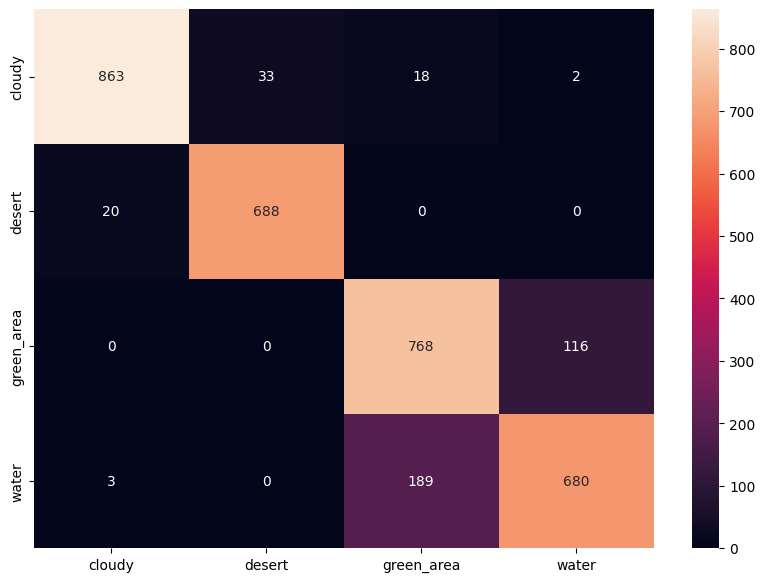

In [47]:
try:
    import seaborn as sb  # Try importing seaborn
except:
    %pip install seaborn  # If seaborn is not installed, install it
    import seaborn as sb  # Then import seaborn


# Assuming 'class_names' is a list of class names in the same order as your confusion matrix
class_names = ['cloudy', 'desert', 'green_area', 'water']

# Assuming 'conmat' is a confusion matrix object
x=conmat.compute().cpu().numpy()
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sb.heatmap(x,annot=True,fmt=".0f", xticklabels=class_names, yticklabels=class_names)

##### 2. Create the classification report

It computes precise evaluation metrics for each class in a multi-class classification task for 100 epochs.

In [48]:
from sklearn.metrics import classification_report  # Importing classification_report from sklearn.metrics

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0  # Initialize the number of correct predictions on the test set
test_total = 0  # Initialize the total number of examples in the test set
predictions = []  # List to store predicted labels
true_labels = []  # List to store true labels

# Iterate over the test data loader
with torch.no_grad():  # Disable gradient computation during inference
    for images, labels in test_loader:
        images = images.to(device)  # Move images to the device (GPU if available)
        labels = labels.to(device)  # Move labels to the device

        outputs = model(images)  # Forward pass through the model
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        predictions.extend(predicted.cpu().numpy())  # Append predicted labels to the list
        true_labels.extend(labels.cpu().numpy())  # Append true labels to the list

        test_total += labels.size(0)  # Increment total number of examples
        test_correct += (predicted == labels).sum().item()  # Increment correct predictions

test_accuracy = test_correct / test_total  # Calculate test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')  # Print test accuracy

# Generate classification report
print(classification_report(true_labels, predictions, target_names=test_data.dataset.classes))  # Print classification report

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy: 0.9043
              precision    recall  f1-score   support

      cloudy       0.96      0.96      0.96       147
      desert       0.97      0.96      0.97       120
  green_area       0.83      0.89      0.86       150
       water       0.88      0.82      0.85       147

    accuracy                           0.90       564
   macro avg       0.91      0.91      0.91       564
weighted avg       0.91      0.90      0.90       564



##### 3. Determine the precision, recall, and F1 score

For each class, compute the precision, recall, and F1-score across 100 epochs. Also, determine the total statistics. 

In [50]:
from sklearn.metrics import precision_recall_fscore_support
# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average=None)
class_names = test_data.dataset.classes

# Create a dictionary to store class-wise evaluation metrics
class_metrics = {}
for i, class_name in enumerate(class_names):
    class_metrics[class_name] = {
        "Precision": precision[i],
        "Recall": recall[i],
        "F1-score": f1_score[i]
    }

# Print class-wise evaluation metrics
class_metrics_df = pd.DataFrame(class_metrics)
print(class_metrics_df)

             cloudy    desert  green_area     water
Precision  0.959184  0.974576    0.827160  0.875912
Recall     0.959184  0.958333    0.893333  0.816327
F1-score   0.959184  0.966387    0.858974  0.845070


Code continued for Architecture 4 in code3 file.